<a href="https://colab.research.google.com/github/simrant27/CatoonifyMe/blob/main/CartoonGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix



In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Load hyperparameters
with open("/content/config.json", "r") as f:
    config = json.load(f)

# original_dir = config["original_dir"]
# cartoon_dir = config["cartoon_dir"]
batch_size = config["batch_size"]
total_epochs = config["total_epochs"]
lambda_l1 = config["lambda_l1"]
learning_rate = config["learning_rate"]
limit = config["dataset_limit"]
beta1 = config["beta1"]
beta2 = config["beta2"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
from huggingface_hub import hf_hub_download


In [15]:
import pandas as pd
from huggingface_hub import hf_hub_download
from PIL import Image
import io

def load_dataset():
    # Download the parquet file
    file_path = hf_hub_download(
        repo_id="bhadresh-savani/photo-to-cartoon",
        filename="data/train-00000-of-00001-035009adcbbb5feb.parquet",
        repo_type="dataset"
    )

    # Load into pandas
    df = pd.read_parquet(file_path)

    # Convert bytes to PIL Images
    def bytes_to_image(bytes_data):
        return Image.open(io.BytesIO(bytes_data)).convert('RGB')

    df['photo'] = df['imageA'].apply(lambda x: bytes_to_image(x['bytes']))
    df['cartoon'] = df['imageB'].apply(lambda x: bytes_to_image(x['bytes']))

    return df['photo'], df['cartoon']


In [16]:
original_dir, cartoon_dir = load_dataset()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


data/train-00000-of-00001-035009adcbbb5f(…):   0%|          | 0.00/311M [00:00<?, ?B/s]

In [17]:
class CartoonDataset(Dataset):
    def __init__(self, original_dir, cartoon_dir, transform=None, limit=None):
        self.original_paths = sorted(glob(os.path.join(original_dir, '*.png')))
        self.cartoon_paths = sorted(glob(os.path.join(cartoon_dir, '*.png')))
        if limit:
            self.original_paths = self.original_paths[:limit]
            self.cartoon_paths = self.cartoon_paths[:limit]
        self.transform = transform

    def __len__(self):
        return len(self.original_paths)

    def __getitem__(self, idx):
        real = Image.open(self.original_paths[idx]).convert('RGB')
        cartoon = Image.open(self.cartoon_paths[idx]).convert('RGB')
        if self.transform:
            real = self.transform(real)
            cartoon = self.transform(cartoon)
        return real, cartoon


In [22]:
from torch.utils.data import Dataset

class CartoonDataset(Dataset):
    def __init__(self, original_images, cartoon_images, transform=None, limit=None):
        # Assume original_images and cartoon_images are lists or Series of PIL images
        if limit:
            self.original_images = original_images[:limit]
            self.cartoon_images = cartoon_images[:limit]
        else:
            self.original_images = original_images
            self.cartoon_images = cartoon_images
        self.transform = transform

    def __len__(self):
        return len(self.original_images)

    def __getitem__(self, idx):
        real = self.original_images[idx]
        cartoon = self.cartoon_images[idx]
        if self.transform:
            real = self.transform(real)
            cartoon = self.transform(cartoon)
        return real, cartoon


In [23]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])


In [24]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [26]:
dataset = CartoonDataset(original_dir, cartoon_dir, transform=transform, limit=limit)



In [27]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [28]:
# Instantiate modelsac
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [29]:
# Optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, beta2))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, beta2))

In [30]:
# Loss functions
adversarial_loss = nn.BCELoss()
content_loss = nn.L1Loss()

In [31]:
g_losses = []
d_losses = []
d_accuracies = []

In [ ]:
# os.makedirs("../experiments/exp2/checkpoints", exist_ok=True)
# os.makedirs("../experiments/exp2/losses", exist_ok=True)
# os.makedirs("../experiments/exp2/outputs", exist_ok=True)


In [55]:
base_dir = "/content/drive/MyDrive/final project"

In [32]:

base_dir = "/content/drive/MyDrive/final project"

os.makedirs(os.path.join(base_dir, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "losses"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "outputs"), exist_ok=True)


In [ ]:

base_dir = "/content/drive/My Drive/CartoonifyMe/experiments/exp3"

os.makedirs(os.path.join(base_dir, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "losses"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "outputs"), exist_ok=True)


In [ ]:
#comment this while running it for first time

if os.path.exists("/content/drive/MyDrive/CartoonifyMe/experiments/exp3/losses/losses.json"):
    with open("/content/drive/MyDrive/CartoonifyMe/experiments/exp3/losses/losses.json", "r") as f:
        losses = json.load(f)
        g_losses = losses.get("g_losses", [])
        d_losses = losses.get("d_losses", [])
        d_accuracies = losses.get("d_accuracies", [])


In [34]:
start_epoch = 0

In [ ]:
#comment this while running it for first time and set start_epoch = 0
# Load from checkpoint
checkpoint = torch.load("/content/drive/MyDrive/CartoonifyMe/experiments/exp3/checkpoints/cartoongan_epoch80.pth", weights_only=True)

generator.load_state_dict(checkpoint["generator"])
discriminator.load_state_dict(checkpoint["discriminator"])
g_optimizer.load_state_dict(checkpoint["g_optimizer"])
d_optimizer.load_state_dict(checkpoint["d_optimizer"])
start_epoch = checkpoint["epoch"]

In [35]:
# Resume training
for epoch in range(start_epoch, start_epoch + 100):
    start_time = time.time()
    generator.train()
    discriminator.train()
    g_epoch_loss = 0
    d_epoch_loss = 0
    accuracy_accum = 0
    batch_count = 0

    for real, cartoon in loader:
        real, cartoon = real.to(device), cartoon.to(device)

        # Discriminator training
        fake = generator(real).detach()
        d_real = discriminator(cartoon)
        d_fake = discriminator(fake)

        real_labels = torch.ones_like(d_real)
        fake_labels = torch.zeros_like(d_fake)

        d_loss_real = adversarial_loss(d_real, real_labels)
        d_loss_fake = adversarial_loss(d_fake, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) * 0.5

  # ✅ Accuracy tracking (image-level)
        pred_real_img = (d_real.detach().mean(dim=[1, 2, 3]) > 0.5).float()
        pred_fake_img = (d_fake.detach().mean(dim=[1, 2, 3]) < 0.5).float()
        correct_real = pred_real_img.sum().item()
        correct_fake = pred_fake_img.sum().item()
        total = pred_real_img.numel() + pred_fake_img.numel()
        batch_accuracy = (correct_real + correct_fake) / total
        accuracy_accum += batch_accuracy
        batch_count += 1
              # Accuracy tracking
        # pred_real = (d_real > 0.5).float()
        # pred_fake = (d_fake < 0.5).float()
        # correct_real = pred_real.eq(real_labels).sum().item()
        # correct_fake = pred_fake.eq(fake_labels).sum().item()
        # total = real_labels.numel() + fake_labels.numel()
        # batch_accuracy = (correct_real + correct_fake) / total
        # accuracy_accum += batch_accuracy
        # batch_count += 1

        # correct_real = pred_real_img.sum().item()
        # correct_fake = pred_fake_img.sum().item()
        # total = pred_real_img.numel() + pred_fake_img.numel()
        # batch_accuracy = (correct_real + correct_fake) / total
        # accuracy_accum += batch_accuracy
        # batch_count += 1

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Generator training
        fake = generator(real)
        g_adv = adversarial_loss(discriminator(fake), real_labels)
        g_l1 = content_loss(fake, cartoon)
        g_loss = g_adv + lambda_l1 * g_l1

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        g_epoch_loss += g_loss.item()
        d_epoch_loss += d_loss.item()


    end_time = time.time()  # ⏱️ End timer
    epoch_time = end_time - start_time
    epoch_accuracy = accuracy_accum / batch_count

    g_losses.append(g_epoch_loss / len(loader))
    d_losses.append(d_epoch_loss / len(loader))
    d_accuracies.append(epoch_accuracy)



    # Evaluation for confusion matrix
    if (epoch + 1) % 10 == 0:
        generator.eval()
        discriminator.eval()
        all_labels, all_preds = [], []

        with torch.no_grad():
            for real, cartoon in loader:
                real, cartoon = real.to(device), cartoon.to(device)
                d_real = discriminator(cartoon)
                d_fake = discriminator(generator(real))

                d_real_img = d_real.mean(dim=[1, 2, 3])
                d_fake_img = d_fake.mean(dim=[1, 2, 3])

                preds_real = (d_real_img > 0.5).int().cpu().numpy()
                preds_fake = (d_fake_img > 0.5).int().cpu().numpy()
                labels_real = torch.ones_like(d_real_img).int().cpu().numpy()
                labels_fake = torch.zeros_like(d_fake_img).int().cpu().numpy()

                all_preds.extend(preds_real)
                all_preds.extend(preds_fake)
                all_labels.extend(labels_real)
                all_labels.extend(labels_fake)

        os.makedirs(os.path.join(base_dir, "logs"), exist_ok=True)
        cm = confusion_matrix(all_labels, all_preds)
        cm_df = pd.DataFrame(cm, index=["Fake", "Real"], columns=["Pred Fake", "Pred Real"])
        cm_df.to_csv(os.path.join(base_dir, "logs", f"confusion_epoch_{epoch+1}.csv"))


    print(f"Epoch {epoch+1} | G Loss: {g_epoch_loss/len(loader):.4f} | D Loss: {d_epoch_loss/len(loader):.4f} | Acc: {epoch_accuracy:.4f} | Time: {epoch_time:.2f}s")

  # Save model and losses every epoch
    with open(os.path.join(base_dir, "losses", "losses.json"), "w") as f:
        json.dump({"g_losses": g_losses, "d_losses": d_losses,  "d_accuracies": d_accuracies}, f)
     # Save every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'g_optimizer': g_optimizer.state_dict(),
            'd_optimizer': d_optimizer.state_dict(),
            'epoch': epoch + 1
        }, os.path.join(base_dir, "checkpoints", f"cartoongan_epoch{epoch+1}.pth")

        )




Epoch 1 | G Loss: 44.3552 | D Loss: 0.5877 | Acc: 0.9211 | Time: 5.11s
Epoch 2 | G Loss: 24.4775 | D Loss: 0.5339 | Acc: 0.9671 | Time: 3.24s
Epoch 3 | G Loss: 19.8082 | D Loss: 0.5289 | Acc: 0.9013 | Time: 3.13s
Epoch 4 | G Loss: 18.0718 | D Loss: 0.5620 | Acc: 0.8882 | Time: 4.27s
Epoch 5 | G Loss: 16.8079 | D Loss: 0.5411 | Acc: 0.8684 | Time: 3.19s
Epoch 6 | G Loss: 15.4930 | D Loss: 0.5329 | Acc: 0.9013 | Time: 3.13s
Epoch 7 | G Loss: 14.8439 | D Loss: 0.5622 | Acc: 0.9211 | Time: 3.36s
Epoch 8 | G Loss: 14.0594 | D Loss: 0.5539 | Acc: 0.8750 | Time: 4.17s
Epoch 9 | G Loss: 13.8376 | D Loss: 0.5167 | Acc: 0.8684 | Time: 3.15s
Epoch 10 | G Loss: 13.9917 | D Loss: 0.5043 | Acc: 0.9079 | Time: 3.16s
Epoch 11 | G Loss: 13.9200 | D Loss: 0.5002 | Acc: 0.9276 | Time: 4.30s
Epoch 12 | G Loss: 13.1707 | D Loss: 0.5487 | Acc: 0.8882 | Time: 3.22s
Epoch 13 | G Loss: 12.8975 | D Loss: 0.4746 | Acc: 0.9211 | Time: 3.27s
Epoch 14 | G Loss: 13.0711 | D Loss: 0.5220 | Acc: 0.8553 | Time: 3.83s
E

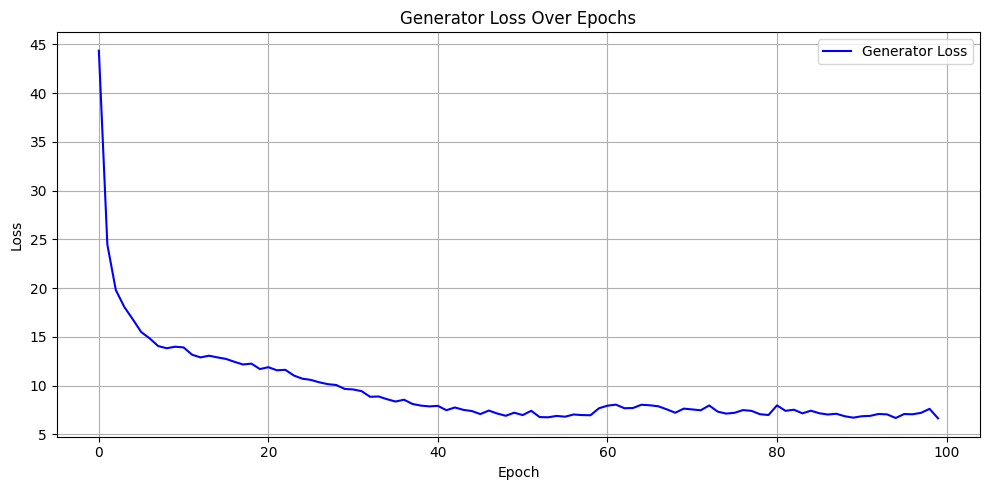

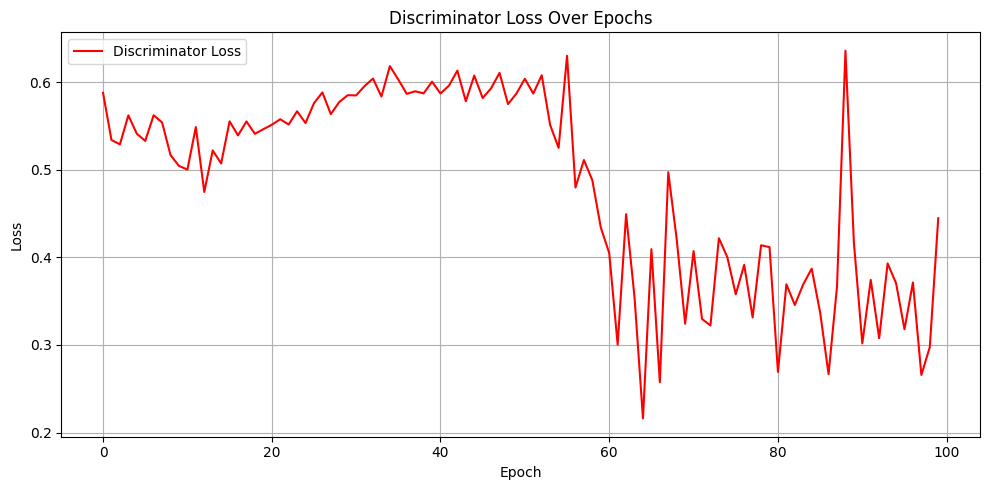

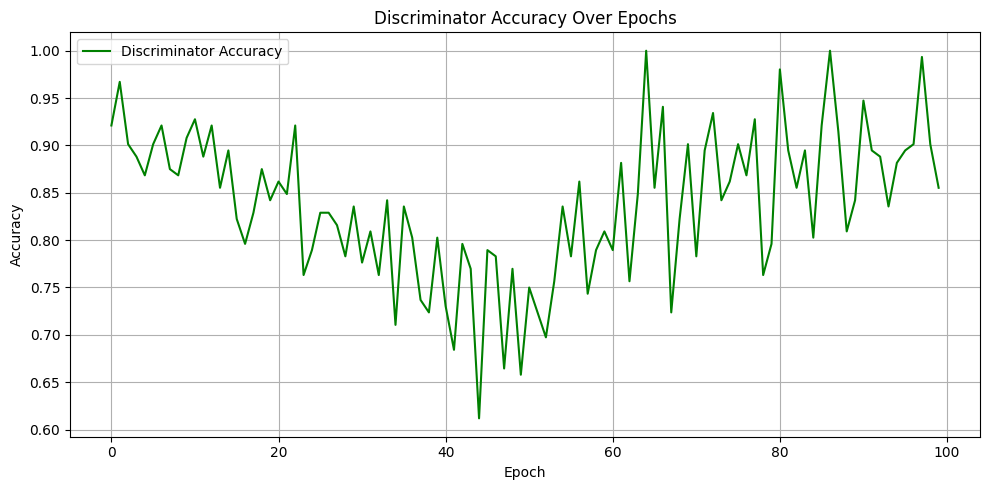

In [36]:
import matplotlib.pyplot as plt

# Plot Generator Loss
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Discriminator Loss
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(d_accuracies, label="Discriminator Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Discriminator Accuracy Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [37]:

print(f"Total training samples: {len(dataset)}")


Total training samples: 76


In [ ]:
pip install scikit-learn


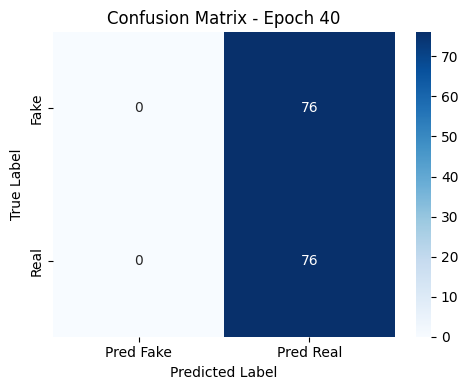

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set correct base path and epoch
epoch = 40  # or any other available epoch

# Load confusion matrix CSV
csv_path = os.path.join(base_dir, "logs", f"confusion_epoch_{epoch}.csv")
cm_df = pd.read_csv(csv_path, index_col=0)

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - Epoch {epoch}")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [39]:
print(g_losses)


[44.35518013803583, 24.477533440840872, 19.80820575513338, 18.071822015862715, 16.80791157170346, 15.492966802496658, 14.843851240057694, 14.059368484898618, 13.837638051886307, 13.991748759621068, 13.919991944965563, 13.17065113469174, 12.897529802824321, 13.071052852429842, 12.895831108093262, 12.740578099300986, 12.442497203224583, 12.171291401511745, 12.257265793649774, 11.699599115472092, 11.89453817668714, 11.57360257600483, 11.622573852539062, 11.040833975139417, 10.714387893676758, 10.591029970269455, 10.344480665106522, 10.15585036026804, 10.065027638485557, 9.665040969848633, 9.60982588717812, 9.432617413370233, 8.856995432000412, 8.88807090960051, 8.607843650014777, 8.370326343335604, 8.556901530215615, 8.120046490117124, 7.952063309518914, 7.872667438105533, 7.924990503411544, 7.48093665273566, 7.760213274704783, 7.516853508196379, 7.395184567100124, 7.082576049001593, 7.445809941542776, 7.140566549803081, 6.909811421444542, 7.224517596395392, 6.98076858018574, 7.4206712622

**Interface.ipynb**

In [ ]:
!pip install matplotlib


In [40]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [41]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


In [42]:
def load_generator(model_path, device):
    model = UNetGenerator().to(device)
    state_dict = torch.load(model_path, map_location=device)

    # Support both full checkpoint and just the generator weights
    if "generator" in state_dict:
        model.load_state_dict(state_dict["generator"])
    else:
        model.load_state_dict(state_dict)

    model.eval()
    return model

In [43]:
# 3. Preprocess Input Image
# ======================
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    original_size = image.size
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    tensor = transform(image).unsqueeze(0)
    return tensor, image, original_size


In [44]:
# 4. Postprocess Output Tensor
# ======================
def postprocess_tensor(tensor):
    tensor = tensor.squeeze(0).detach().cpu()
    tensor = (tensor * 0.5 + 0.5).clamp(0, 1)  # De-normalize
    return transforms.ToPILImage()(tensor)


In [45]:
def cartoonize_image(model_path, input_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_generator(model_path, device)

    input_tensor, original_image, original_size = preprocess_image(input_path)
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        output_tensor = model(input_tensor)

    cartoon_image = postprocess_tensor(output_tensor)
    cartoon_image = cartoon_image.resize(original_size, Image.LANCZOS)

    return cartoon_image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


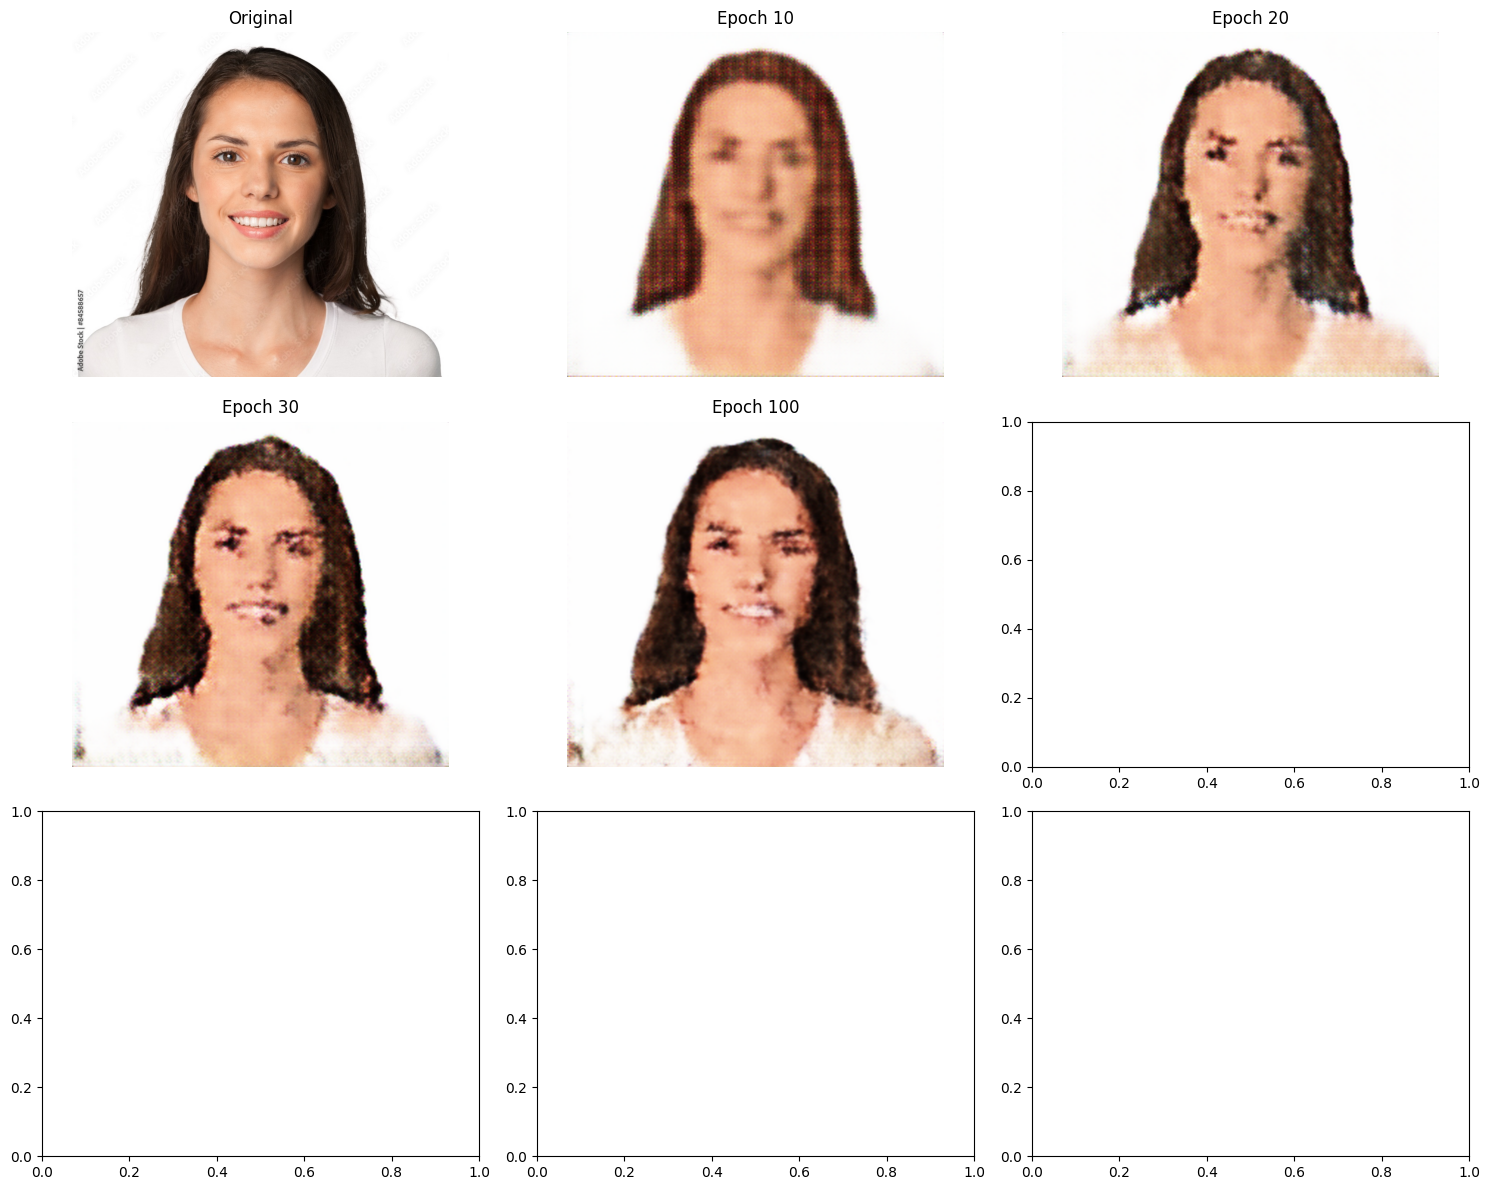

In [54]:
import matplotlib.pyplot as plt
from PIL import Image

input_image_path = "/content/image.jpg"
# Checkpoints and corresponding labels
checkpoints = {
    "Original": None,
    "Epoch 10": "cartoongan_epoch10.pth",
    "Epoch 20": "cartoongan_epoch20.pth",
    "Epoch 30": "cartoongan_epoch30.pth",
    "Epoch 100": "cartoongan_epoch100.pth",  # ✅ corrected
}


# Run cartoonization for each checkpoint
results = {}
for label, ckpt in checkpoints.items():
    if ckpt is None:
        results[label] = Image.open(input_image_path)
    else:
        ckpt_path = f"/content/drive/MyDrive/Datasets/Trained_new/checkpoints/{ckpt}"
        cartoon_img = cartoonize_image(ckpt_path, input_image_path)
        results[label] = cartoon_img

# Plotting in 2 rows and 4 columns
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, (label, image) in enumerate(results.items()):
    ax = axes[i // 3][i % 3]
    ax.imshow(image)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()

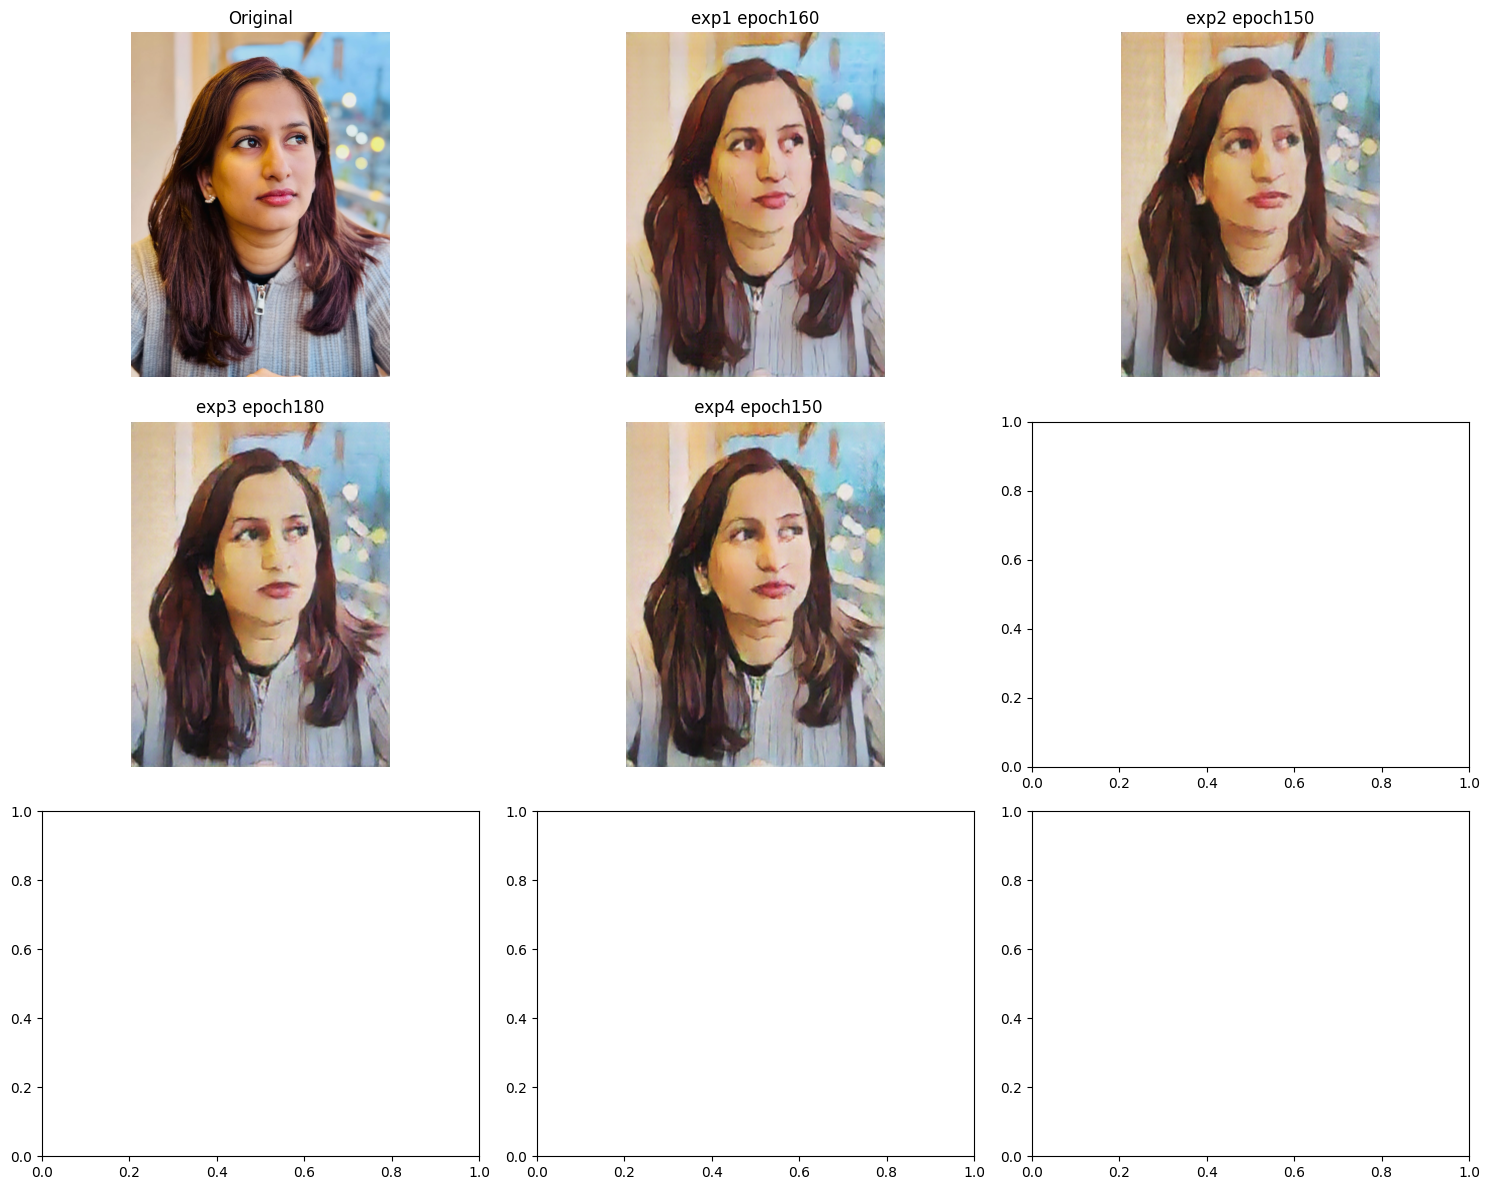

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

input_image_path = "/content/752B3CE9-CE8F-4BC9-B0CF-DA62EF0B9051_Original.jpg"
# Checkpoints and corresponding labels
checkpoints = {
    "Original": None,
    #  "Epoch 10": "cartoongan_epoch10.pth",
    #  "Epoch 20": "cartoongan_epoch20.pth",
    #  "Epoch 30": "cartoongan_epoch30.pth",
    # "Epoch 40": "cartoongan_epoch150(exp2).pth",
    "exp1 epoch160": "/content/drive/MyDrive/final project/cartoongan_epoch160(exp1).pth",
    "exp2 epoch150": "/content/drive/MyDrive/final project/cartoongan_epoch150(exp2).pth",
    "exp3 epoch180": "/content/drive/MyDrive/CartoonifyMe/experiments/exp3/checkpoints/cartoongan_epoch180.pth",

    " exp4 epoch150": "/content/drive/MyDrive/final project/cartoongan_epoch150(exp4).pth",


}

# Run cartoonization for each checkpoint
results = {}
for label, ckpt in checkpoints.items():
    if ckpt is None:
        results[label] = Image.open(input_image_path)
    else:
        ckpt_path = f"{ckpt}"
        cartoon_img = cartoonize_image(ckpt_path, input_image_path)
        results[label] = cartoon_img

# Plotting in 2 rows and 4 columns
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, (label, image) in enumerate(results.items()):
    ax = axes[i // 3][i % 3]
    ax.imshow(image)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()

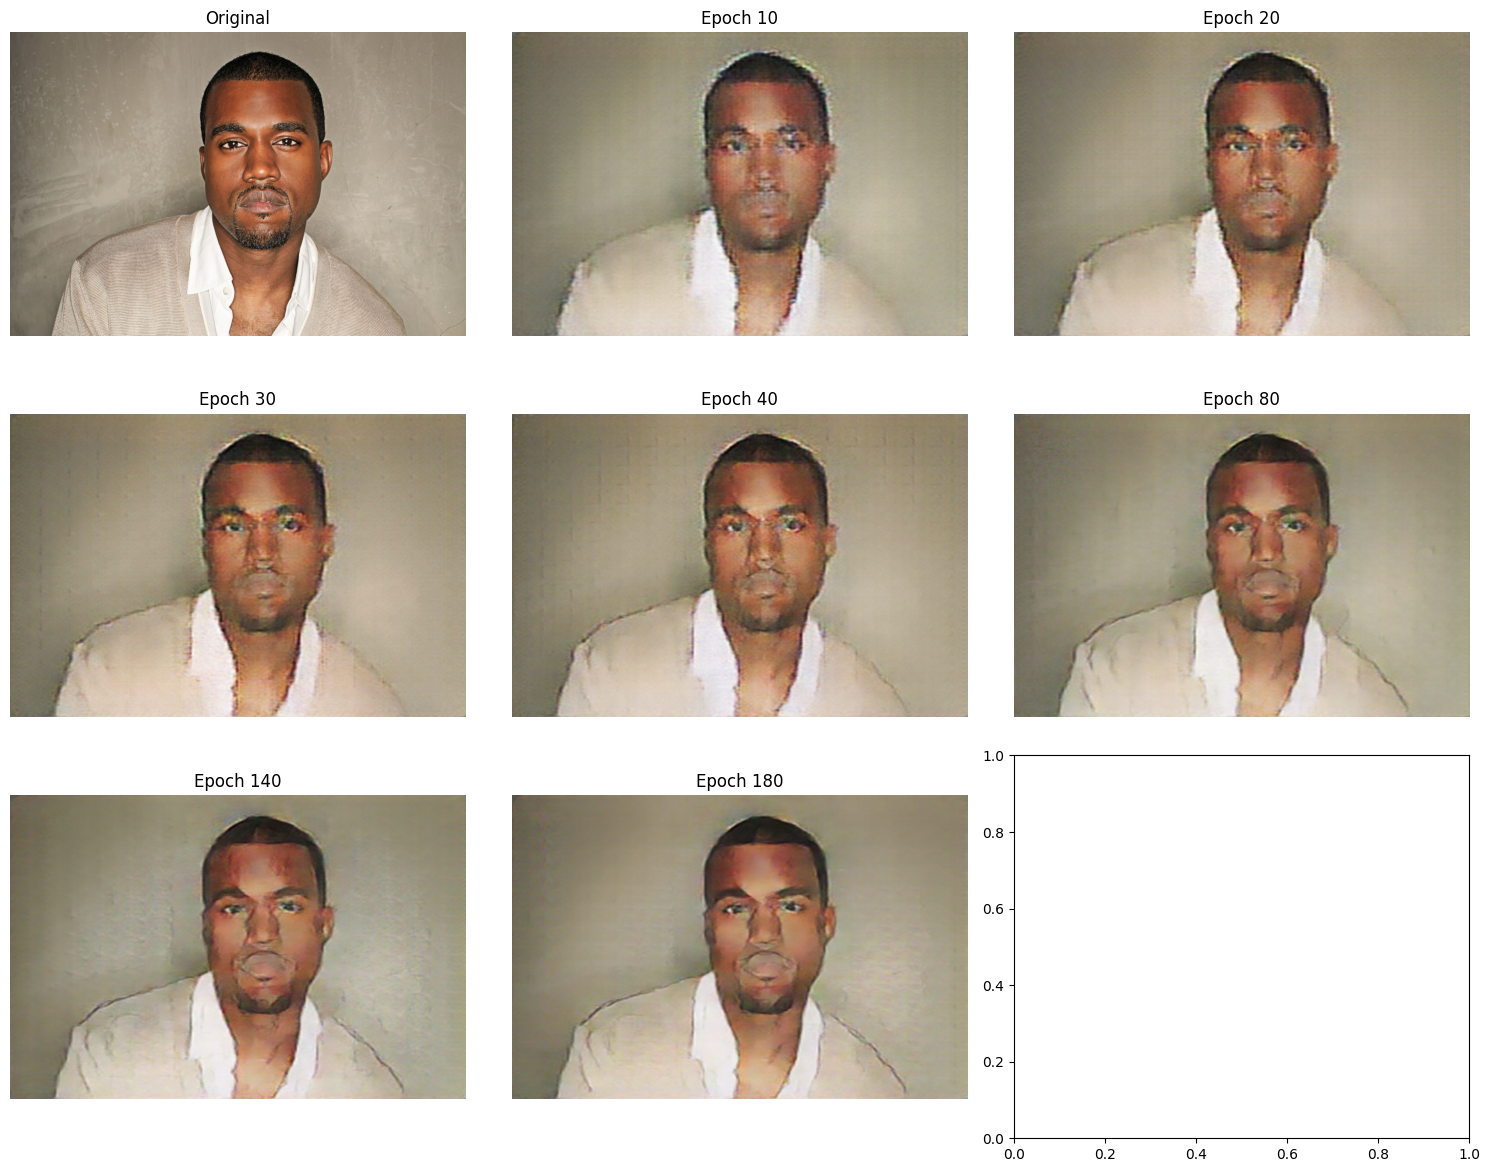

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

input_image_path = "/content/kawai-matthews-kanye-west-1.jpg"
# Checkpoints and corresponding labels
checkpoints = {
    "Original": None,
     "Epoch 10": "cartoongan_epoch10.pth",
     "Epoch 20": "cartoongan_epoch20.pth",
     "Epoch 30": "cartoongan_epoch30.pth",
    "Epoch 40": "cartoongan_epoch40.pth",
    # "Epoch 50": "cartoongan_epoch50.pth",
    "Epoch 80": "cartoongan_epoch80.pth",
    "Epoch 140": "cartoongan_epoch140.pth",
    "Epoch 180": "cartoongan_epoch180.pth",

}

# Run cartoonization for each checkpoint
results = {}
for label, ckpt in checkpoints.items():
    if ckpt is None:
        results[label] = Image.open(input_image_path)
    else:
        ckpt_path = f"/content/drive/MyDrive/CartoonifyMe/experiments/exp3/checkpoints/{ckpt}"
        cartoon_img = cartoonize_image(ckpt_path, input_image_path)
        results[label] = cartoon_img

# Plotting in 2 rows and 4 columns
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, (label, image) in enumerate(results.items()):
    ax = axes[i // 3][i % 3]
    ax.imshow(image)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

input_image_path = "/content/kawai-matthews-kanye-west-1.jpg"

# Checkpoints and corresponding labels
checkpoints = {
    "Original": None,
    "Epoch 20": "cartoongan_epoch20.pth",
    "Epoch 40": "cartoongan_epoch40.pth",
    "Epoch 60": "cartoongan_epoch60.pth",
    "Epoch 80": "cartoongan_epoch80.pth",
    "Epoch 100": "cartoongan_epoch100.pth",
    "Epoch 120": "cartoongan_epoch120.pth",
    "Epoch 140": "cartoongan_epoch140.pth",
    "Epoch 150": "cartoongan_epoch150.pth",

}

# Run cartoonization for each checkpoint
results = {}
for label, ckpt in checkpoints.items():
    if ckpt is None:
        results[label] = Image.open(input_image_path)
    else:
        ckpt_path = f"/content/drive/MyDrive/final project/cartoongan_epoch160(exp1).pth"
        cartoon_img = cartoonize_image(ckpt, input_image_path)
        results[label] = cartoon_img

# Plotting in 2 rows and 4 columns
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, (label, image) in enumerate(results.items()):
    ax = axes[i // 3][i % 3]
    ax.imshow(image)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/kawai-matthews-kanye-west-1.jpg'

In [ ]:
# Replace with your actual paths
model_path120 = "cartoongan_epoch120.pth"
model_path130 = "cartoongan_epoch140.pth"
model_path80 = "cartoongan_epoch80.pth"

model_path10 = "cartoongan_epoch10.pth"

input_image_path = "../sujata_adhikari.jpg"
output_image_path = "my_photo_cartoon.jpg"

cartoon_image = cartoonize_image(model_path150, input_image_path, output_image_path)

cartoon_image2 = cartoonize_image(model_path80, input_image_path, output_image_path)
cartoon_image2 = cartoonize_image(model_path120, input_image_path, output_image_path)
cartoon_image2 = cartoonize_image(model_path130, input_image_path, output_image_path)

